## 3 - Candle Analysis - PATTERNS RECO HERE, WITH WINS / LOSSES AND TRYING TO FIND SOME CANDLES THAT STATISTICALLY COULD BE USED FOR TRADES, IN ALL TIMEFRAMES (basically backtesting but with data)

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv("btcdata.csv")
df = df.dropna() #remove rows with no value
df['Timestamp'] = pd.to_datetime(df['Timestamp'], unit='s')
df = df.set_index('Timestamp')


### min by min analysis on 2024, when we have some candle pattern


Total Trades: 5505
Wins: 1999
Losses: 3506
Win Rate: 36.31%
Final Balance: -361628.62


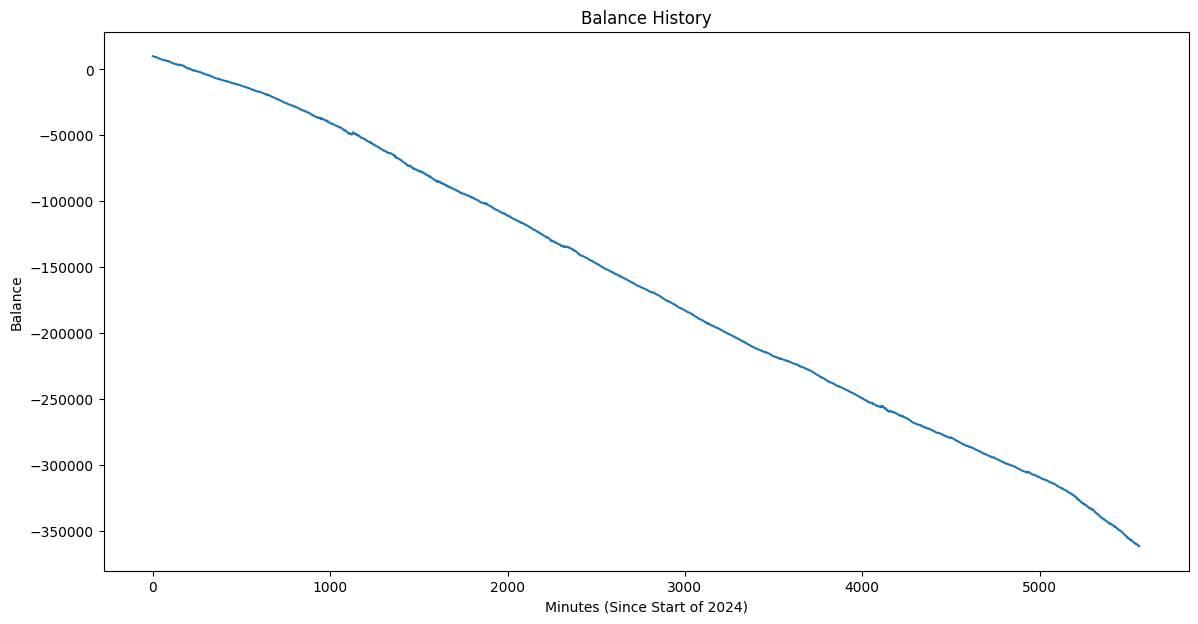

In [40]:
# --- Filter for 2024 ---
df = df.loc['2024']

def analyze_candles(data, rr_ratio=2, candle_size_multiplier=10, fee_percentage=0.00055, initial_balance=10000):
    #BYBIT FEES : Non-VIP MAKER 0.0200 %	TAKER 0.0550 %   we go taker here since we take a long/short in the moment instantly 
    """
    Analyzes candles, tracks wins/losses, and calculates balance with taker fees.

    Args:
        data: DataFrame with 'Open', 'High', 'Low', 'Close' columns.
        rr_ratio: Risk/Reward ratio.
        candle_size_multiplier: Multiplier for wick-to-body ratio.
        fee_percentage: Taker fee percentage (e.g., 0.005 for 0.5%).
        initial_balance: Starting balance.

    Returns:
        Tuple: (results_df, win_loss_array, trades_df, balance_history)
    """
    data['Signal'] = 0
    data['Result'] = 0
    in_position = False
    entry_price = 0
    stop_loss = 0
    take_profit = 0
    trades = []
    balance = initial_balance
    balance_history = [balance]  # Initialize with starting balance

    for i in range(1, len(data)):
        open_price = data['Open'][i]
        high_price = data['High'][i]
        low_price = data['Low'][i]
        close_price = data['Close'][i]

        # --- Long Signal Check ---
        if (close_price > open_price and
            (open_price - low_price) >= candle_size_multiplier * (close_price - open_price)):
                data.loc[data.index[i], 'Signal'] = 1

        # --- Short Signal Check ---
        elif (close_price < open_price and
                (high_price - open_price) >= candle_size_multiplier * (open_price - close_price)):
                data.loc[data.index[i], 'Signal'] = -1

        # --- Trade Entry and SL/TP Calculation ---
        if data['Signal'][i] == 1 and not in_position: # Long
            in_position = True
            entry_price = close_price  # Taker order at close price
            stop_loss = low_price
            take_profit = entry_price + rr_ratio * (entry_price - stop_loss)
            fee = entry_price * fee_percentage  # Taker fee on entry
            balance -= fee
            trades.append([data.index[i], "Long", entry_price, take_profit, stop_loss, fee, 0]) #Added exit price

        elif data['Signal'][i] == -1 and not in_position:  # Short
            in_position = True
            entry_price = close_price  # Taker order at close price
            stop_loss = high_price
            take_profit = entry_price - rr_ratio * (stop_loss - entry_price)
            fee = entry_price * fee_percentage  # Taker fee on entry
            balance -= fee
            trades.append([data.index[i], "Short", entry_price, take_profit, stop_loss, fee, 0]) #Added exit price

        # --- Check for Exit (SL or TP Hit) ---
        if in_position:
          for j in range(i+1, len(data)):
            if data['Signal'][i] == 1: #Long
              if data['Low'][j] <= stop_loss:
                data.loc[data.index[j], 'Result'] = -1
                exit_price = stop_loss  # Exit at stop loss
                fee = exit_price * fee_percentage  # Taker fee on exit
                balance -= ((entry_price - exit_price) + fee)
                trades[-1][-1] = exit_price #Update with the exit price

                in_position = False
                entry_price = 0; stop_loss = 0; take_profit = 0 #reset
                break
              elif data['High'][j] >= take_profit:
                data.loc[data.index[j], 'Result'] = 1
                exit_price = take_profit  # Exit at take profit
                fee = exit_price * fee_percentage  # Taker fee on exit
                balance += ((exit_price - entry_price) - fee)
                trades[-1][-1] = exit_price

                in_position = False
                entry_price = 0; stop_loss = 0; take_profit = 0 #reset
                break

            elif data['Signal'][i] == -1: #Short
              if data['High'][j] >= stop_loss:
                data.loc[data.index[j], 'Result'] = -1
                exit_price = stop_loss # Exit at stop loss
                fee = exit_price * fee_percentage # Taker fee on exit
                balance -= ((exit_price - entry_price) + fee)
                trades[-1][-1] = exit_price

                in_position = False
                entry_price = 0; stop_loss = 0; take_profit = 0 #reset
                break

              elif data['Low'][j] <= take_profit:
                data.loc[data.index[j], 'Result'] = 1
                exit_price = take_profit  # Exit at take profit
                fee = exit_price * fee_percentage  # Taker fee on exit
                balance += ((entry_price - exit_price) - fee)
                trades[-1][-1] = exit_price

                in_position = False
                entry_price = 0; stop_loss = 0; take_profit = 0 #reset
                break
          balance_history.append(balance)

    trades_df = pd.DataFrame(trades, columns=['Timestamp', 'Direction', 'Entry', 'Take Profit', 'Stop Loss', 'Entry Fee', 'Exit Price'])
    win_loss_array = data['Result'].to_numpy()
    return data, win_loss_array, trades_df, balance_history

# --- Run the Analysis ---
results_df, win_loss_array, trades_df, balance_history = analyze_candles(df.copy())

# --- Basic Statistics ---
wins = np.count_nonzero(win_loss_array == 1)
losses = np.count_nonzero(win_loss_array == -1)
total_trades = wins + losses
win_rate = (wins / total_trades) * 100 if total_trades > 0 else 0
final_balance = balance_history[-1] if balance_history else 0 # Avoid error

print(f"\nTotal Trades: {total_trades}")
print(f"Wins: {wins}")
print(f"Losses: {losses}")
print(f"Win Rate: {win_rate:.2f}%")
print(f"Final Balance: {final_balance:.2f}")

# --- Visualization (Balance History) ---
plt.figure(figsize=(14, 7))
plt.plot(balance_history)
plt.title('Balance History')
plt.xlabel('Minutes (Since Start of 2024)')
plt.ylabel('Balance')
plt.show()

#### So basically, I found few ratios that are profitable (10 rr + 6/8 full candle size for example, many others, but the lower the rr, the lower the winrate and it becomes non profitable at around <= 5RR), but the fees make them NON PROFITABLE, that's why you probably can't go for a wr that is equivalent of <= 55% for 2RR (so for 4RR that value divided by 2... etc) UNLESS YOU HAVE 0 FEES, which is not possible